In [79]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.table import Table
from cesium import featurize
import sqlite3
from astropy.stats import sigma_clip as sc

plt.ioff()

In [24]:
filename = input("Enter .tbl filename: ")
dataTable = Table.read(filename, format='ipac')

times = dataTable["obsmjd"] 
values = dataTable["mag_autocorr"] 
errors = dataTable["magerr_auto"]
oids = dataTable["oid"]
fids = dataTable["fid"]

printFrequency(times, values, errors)
frequency = float(input("Enter the frequency: "))
period = 1/frequency

Enter .tbl filename: lyrae4.tbl
feature freq1_freq amplitude freq1_amplitude1
channel          0         0                0
0         2.145259     0.604          0.36683
Enter the frequency: 2.145259


In [25]:
def printFrequency(times, values, errors): 
    """ This function obtains the frequency using cesium, which implies the period.

        Arguments:
            dataTable (array-like): this is the .tbl data file downloaded from Caltech
            IRSA website
    """

    # freq1_amplitude1: Get the amplitude of the jth harmonic of the ith frequency from a fitted Lomb-Scargle model.

    features_to_use = ["freq1_freq", "amplitude", "freq1_amplitude1"]

    fset_cesium = featurize.featurize_time_series(times, values, errors, features_to_use=features_to_use)
                                                
    print(fset_cesium)

In [3]:
def zoo_plot(times, values, errors, indexesTempOID, tempOID, fmtToBeUsed, period):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

    # raw light curve
    ax1.errorbar(times[indexesTempOID], values[indexesTempOID], yerr=errors[indexesTempOID], fmt=fmtToBeUsed, 
        markersize=5.75, mec="k", mew=0.59)
    ax1.set_ylim(ax1.get_ylim()[::-1])
    ax1.set_title("LC for oid={} (raw data)".format(tempOID))
    ax1.set_xlabel("time")
    ax1.set_ylabel("brightness (mag)")
    ax1.yaxis.grid(color='gray', linestyle='dashed')
    ax1.xaxis.grid(color='gray', linestyle='dashed')

    # phase-folded light curve
    tempLength = len(indexesTempOID[0])
    timesTemp = np.empty(tempLength)
    timesPhaseFolded = np.empty(tempLength)
    timesTemp = times[indexesTempOID]

    for i in range(tempLength):
        timesPhaseFolded[i] = (timesTemp[i] % period) / period

    timesPhaseFoldedPlusOne = np.empty(tempLength)
    for j in range(tempLength):
        timesPhaseFoldedPlusOne[j] = timesPhaseFolded[j]+1
    ax2.errorbar(timesPhaseFolded, values[indexesTempOID], yerr=errors[indexesTempOID], fmt=fmtToBeUsed, 
        markersize=5.75, mec="k", mew=0.59)
    ax2.errorbar(timesPhaseFoldedPlusOne, values[indexesTempOID], yerr=errors[indexesTempOID], fmt=fmtToBeUsed, 
        markersize=5.75, mec="k", mew=0.59)
    ax2.set_ylim(ax2.get_ylim()[::-1]) # reversing the y-axis as desired  
    ax2.set_title("LC for oid={} (phase-folded)".format(tempOID))
    ax2.set_xlabel("phase")
    ax2.yaxis.grid(color='gray', linestyle='dashed')
    ax2.xaxis.grid(color='gray', linestyle='dashed')

    fig.tight_layout()

In [27]:
def IPAC_Table_Parser(times, values, errors, oids, fids, period): # took out period as argument 
    """ This Zooniverse light curve plotting 
        function produces phase-folded light 
        curves and non-phase-folded light curves 
        (i.e. the raw data) with error bars for each 
        unique object ID from data (.tbl) file obtained  
        from Caltech PTF database.

        Arguments:
            times: array of time values
            values: array of magnitude values
            errors: array of errors on the magnitudes
            oids: array of object ID's
            fids: array of filter ID's
            period (float): the period of the light 
            curve for phase folding (obtained using cesium) 
    """

    length = len(oids)  
    oidsArray = np.empty(length)

    for i in range(length):
        oidsArray[i] = oids[i]

    oidsArraySorted = np.empty(length)
    oidsArraySorted = np.sort(oidsArray) 

    fmtToBeUsed = 'ro'

    index = 0
    swapVar = 0
    tempOID = 0
    newOID = int(oidsArraySorted[index])

    while newOID != tempOID: # while loop because number of unique OID's is not fixed 
        swapVar = newOID
        tempOID = swapVar
        indexesTempOID = 0
        indexesTempOID = np.where(dataTable[3][:] == tempOID)
        fmtToBeUsedNumber = fids[indexesTempOID[0][0]]

        # Filter identifier (1 = g; 2 = R)
        if fmtToBeUsedNumber == 2:
            fmtToBeUsed = 'ro'
        else:
            fmtToBeUsed = 'go'
            
        # THIS IS WHERE THE ERROR IS! TRYING TO APPLY CESIUM TO EACH OID SEPARATELY
        
        #print("times[indexesTempOID]:", times[indexesTempOID])
        #print("values[indexesTempOID]:", values[indexesTempOID])
        #print("errors[indexesTempOID]:", errors[indexesTempOID])
        
        zoo_plot(times, values, errors, indexesTempOID, tempOID, fmtToBeUsed, period)
        
        index += 1
        newOID = int(oidsArraySorted[index]) 
        # at this point, newOID will equal tempOID, unless the there is only one oid of that variety
        while (newOID == tempOID and index < (length-1)): 
            index += 1
            newOID = int(oidsArraySorted[index])

<IPython.core.display.Javascript object>


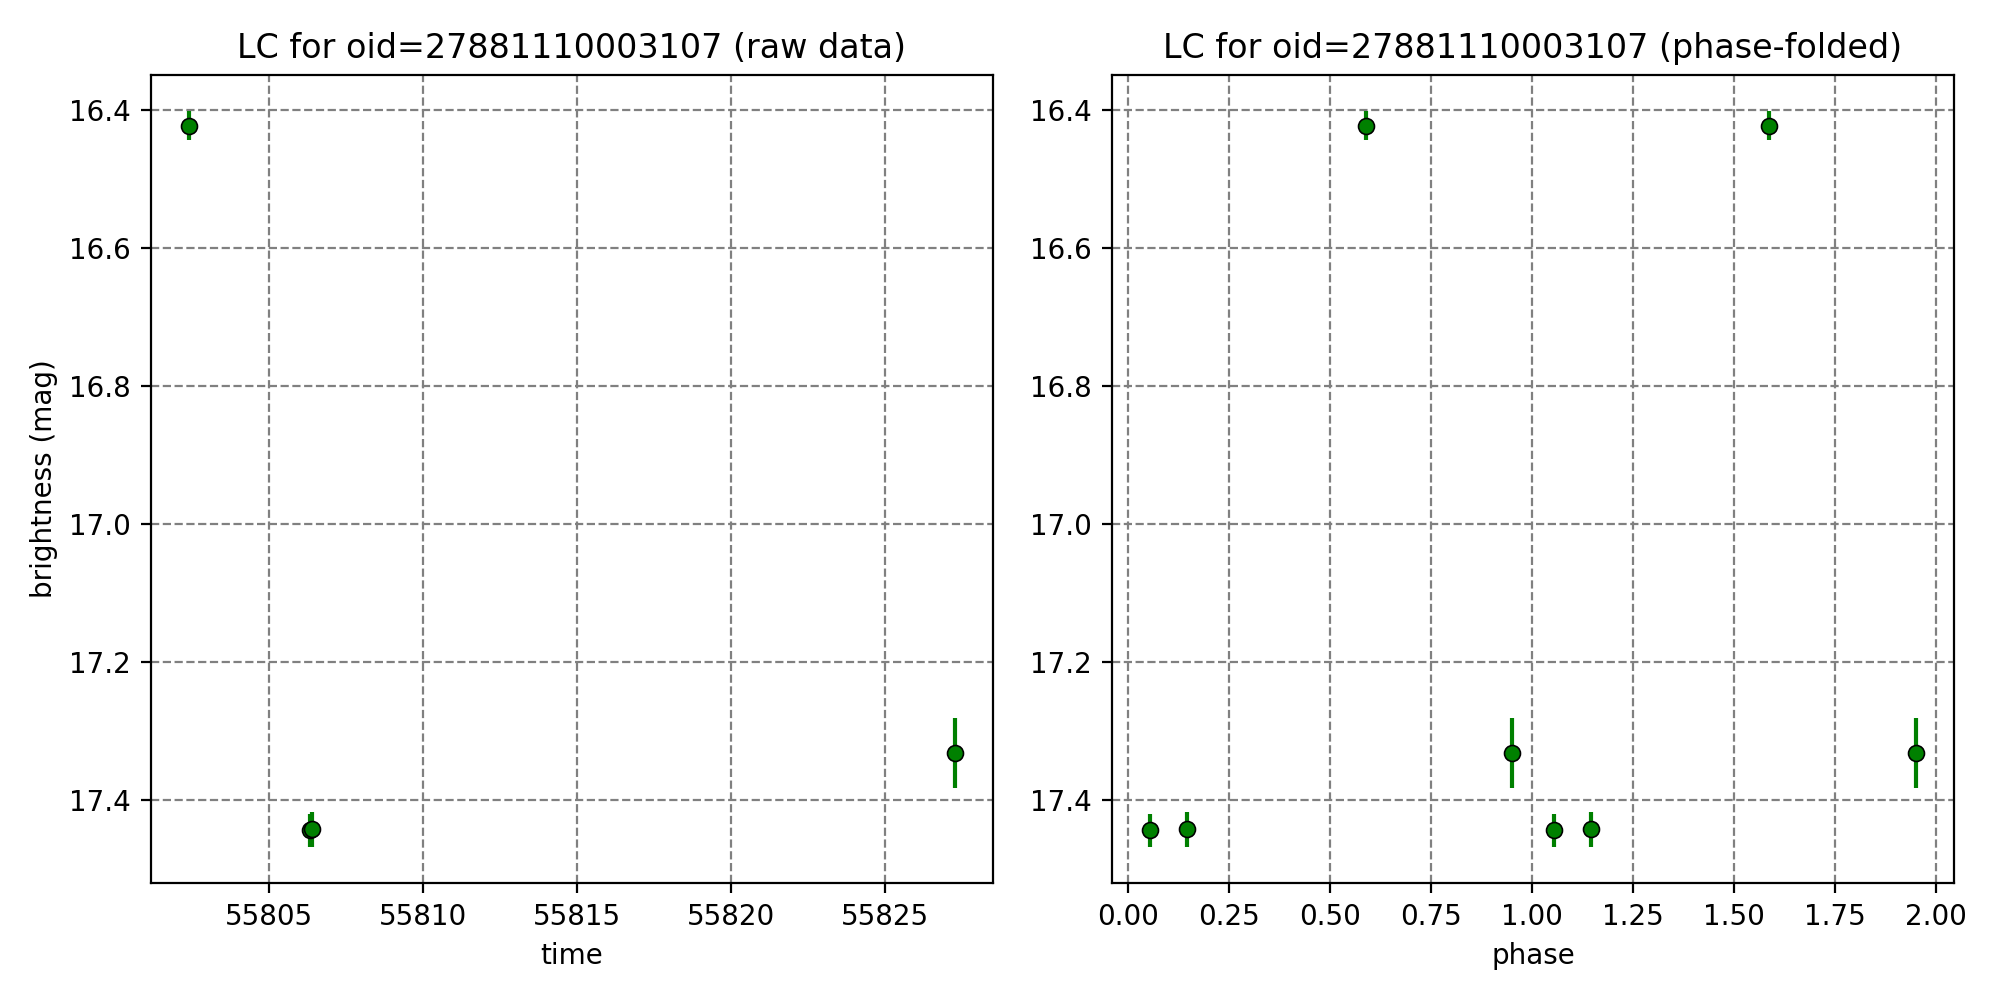

<IPython.core.display.Javascript object>


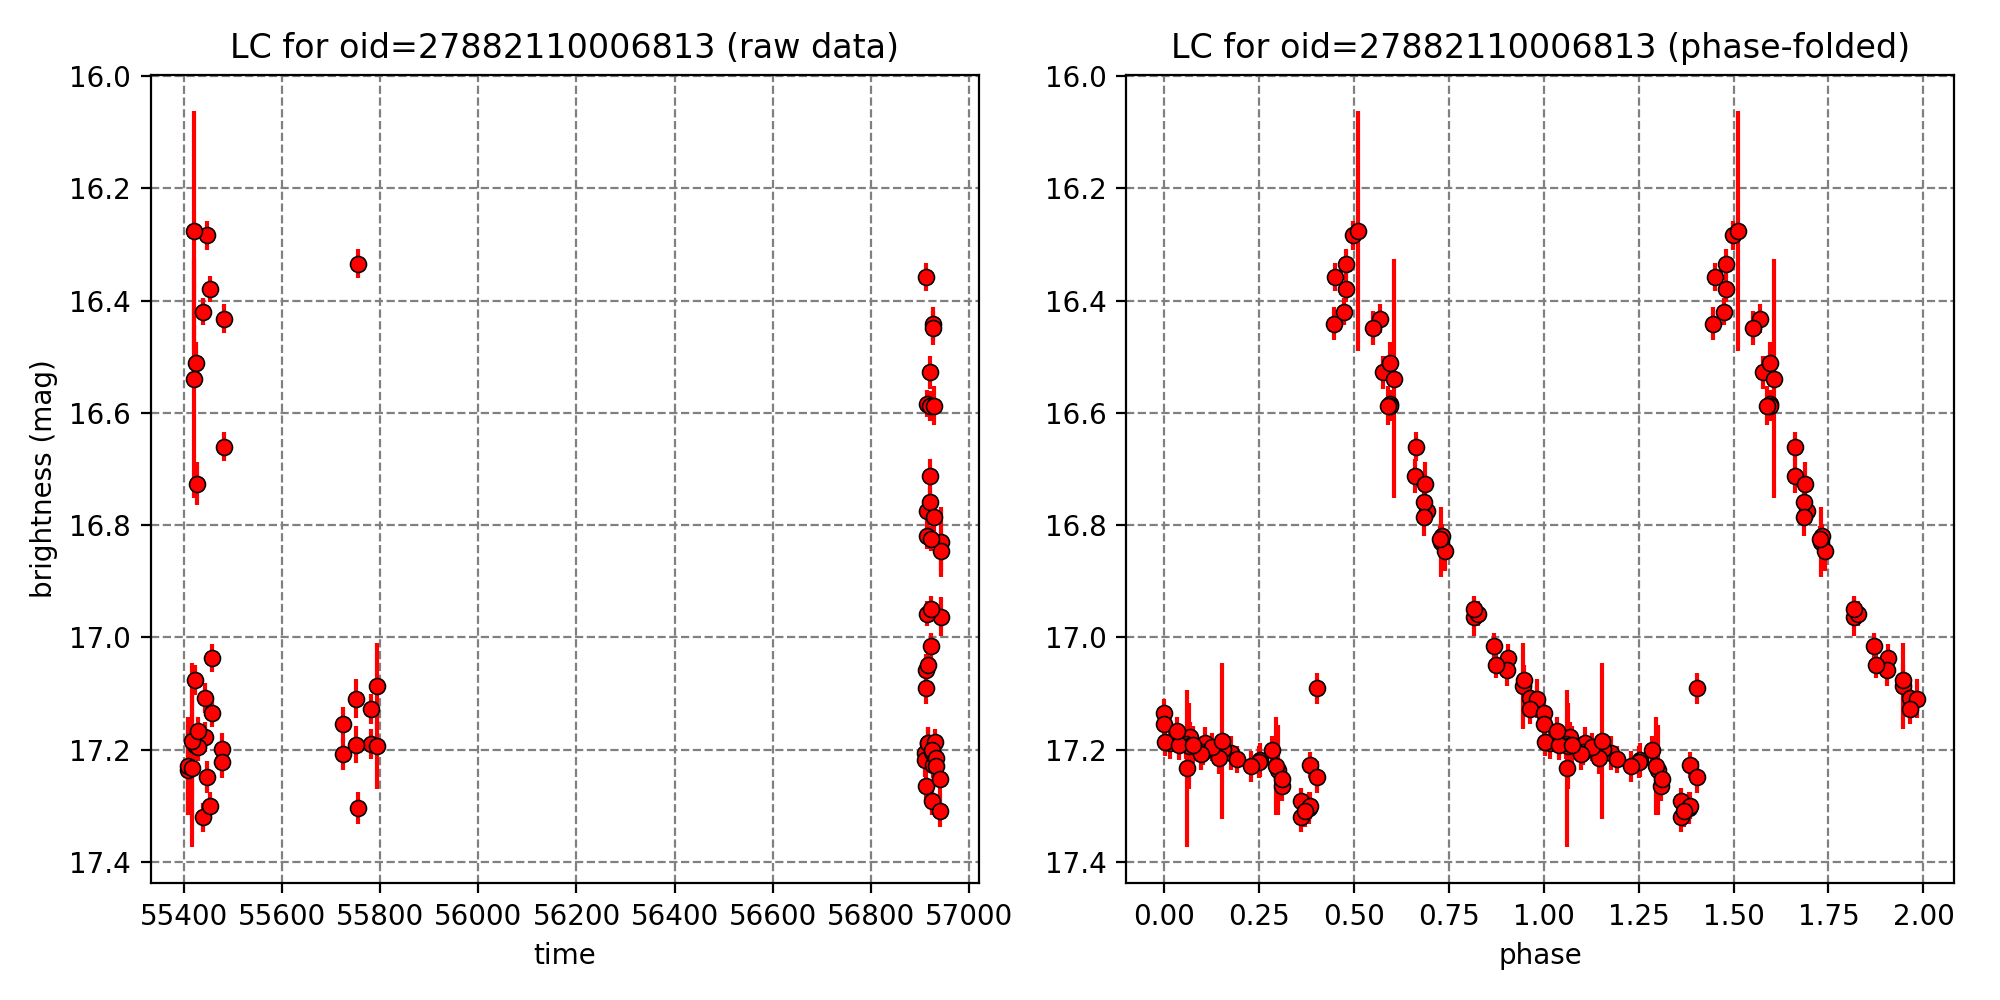

<IPython.core.display.Javascript object>


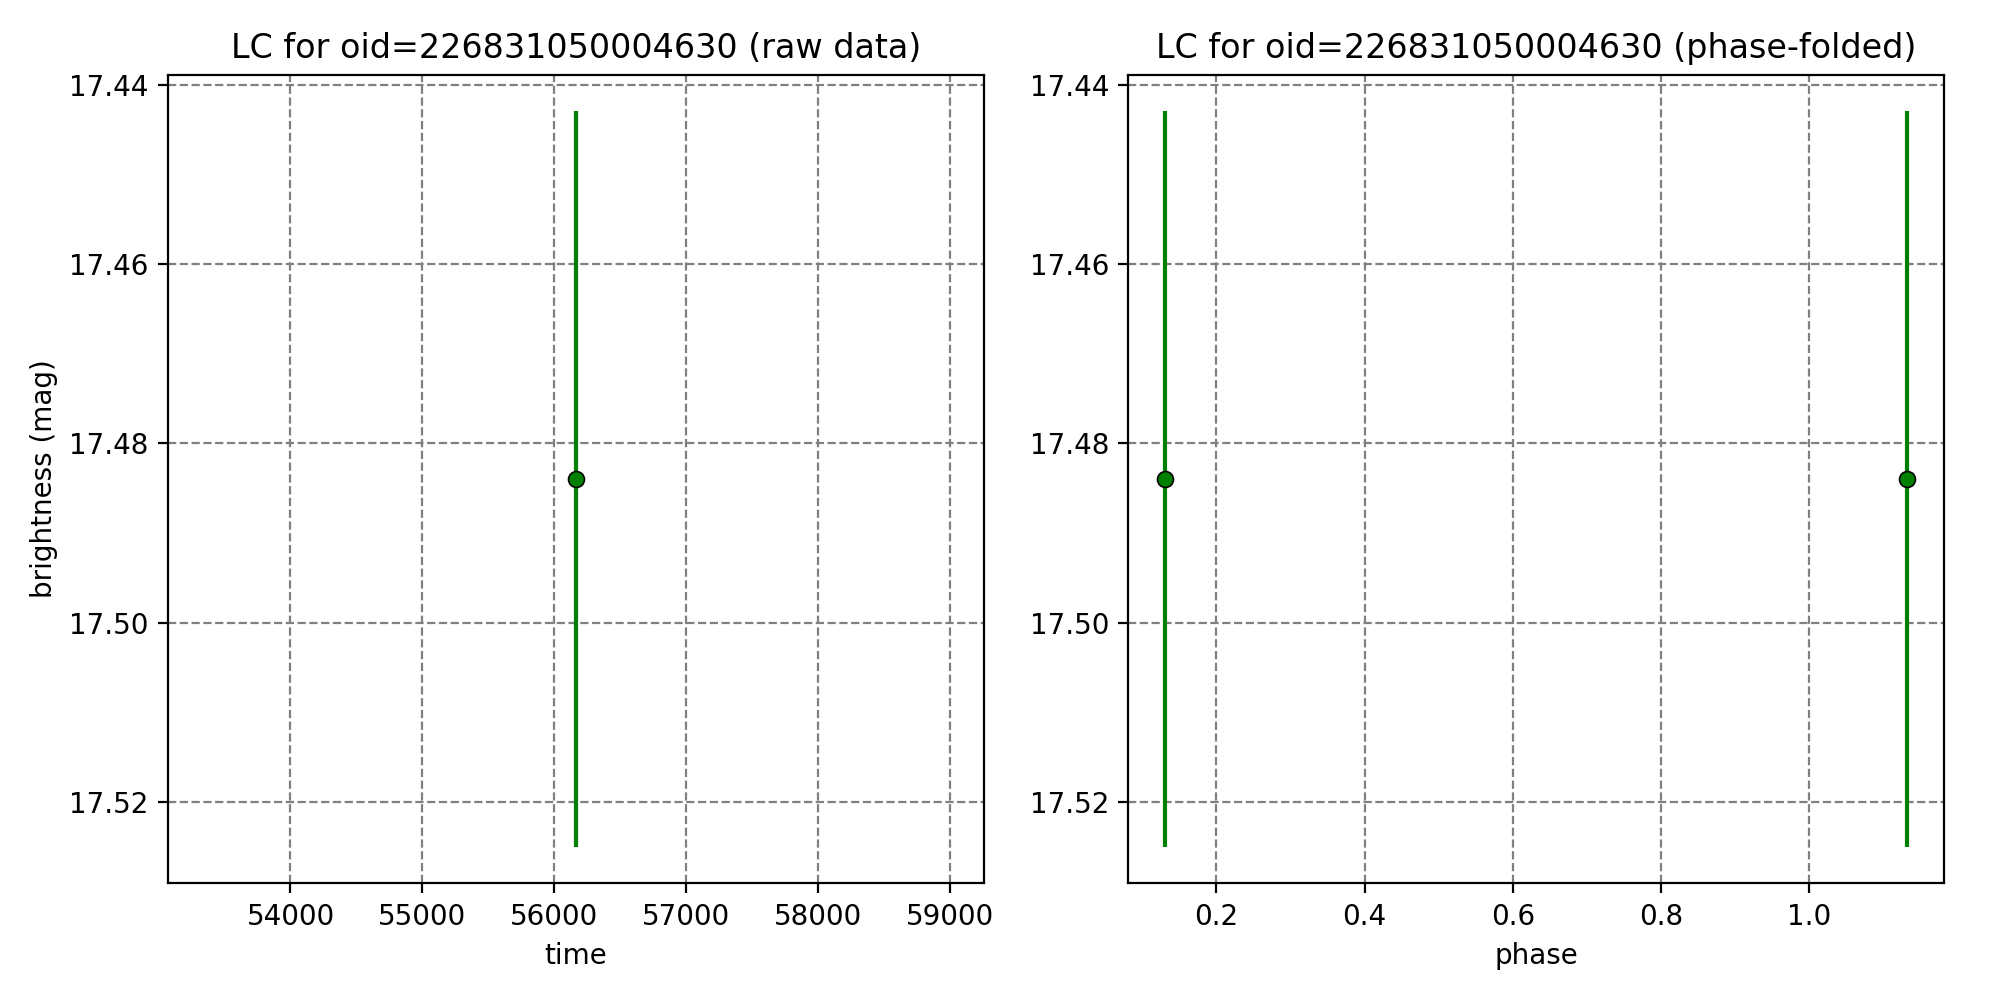

<IPython.core.display.Javascript object>


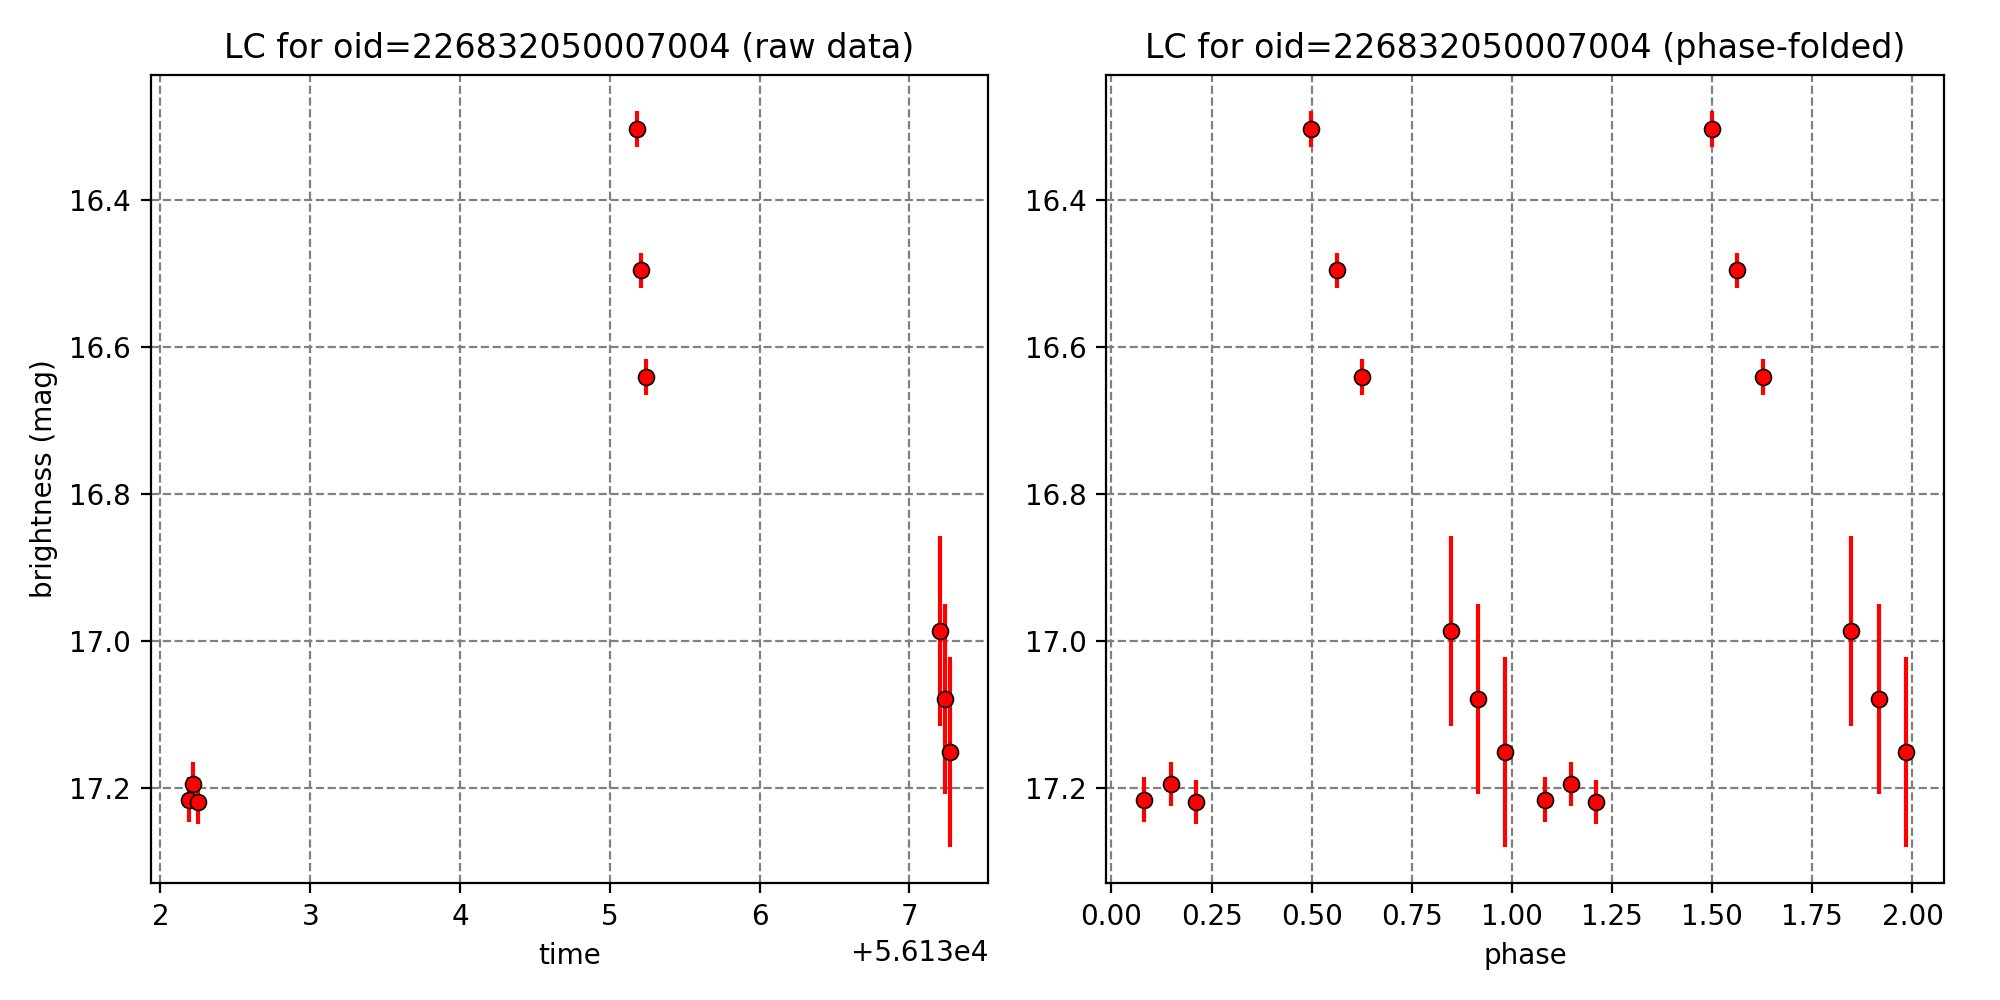

In [28]:
IPAC_Table_Parser(times, values, errors, oids, fids, period)

In [97]:
def zoo_plot2(t, m, m_unc, period = 1.0, ptf_filt = "R"): 
    """Plots PTF data for Zooniverse"""
    
    color_dict = {"g": "MediumAquaMarine", "R": "FireBrick"}
    
    #fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8,8), gridspec_kw = {'height_ratios':[1, 3]}) this works
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    
    # raw light curve
    ax1.errorbar(t, m, m_unc, 
                 fmt = "o", mec="k", mew=0.5, 
                 color = color_dict[ptf_filt])
    ax1.set_ylim(ax1.get_ylim()[::-1])
    ax1.yaxis.grid(color='gray', linestyle='dashed')
    ax1.xaxis.grid(color='gray', linestyle='dashed')
    ax1.set_title("Light Curve (raw data)")
    ax1.set_xlabel("Time (d)")
    ax1.set_ylabel("Brightness (mag)")
        
    # phase folded light curve
    ax2.errorbar(t / period % 1, m, m_unc, 
                 fmt = "o", mec="k", mew=0.5,
                 color = color_dict[ptf_filt])
    ax2.errorbar((t / period % 1)+1, m, m_unc, 
                 fmt = "o", mec="k", mew=0.5,
                 color = color_dict[ptf_filt])
    ax2.set_ylim(ax2.get_ylim()[::-1]) 
    ax2.yaxis.grid(color='gray', linestyle='dashed')
    ax2.xaxis.grid(color='gray', linestyle='dashed')
    ax2.set_title("Light Curve for Object (phase-folded)")
    ax2.set_xlabel("Phase")
    #ax2.set_ylabel("brightness (mag)")
    
    fig.tight_layout()
    return fig

In [6]:
conn = sqlite3.connect('/home/nick/Desktop/NUREU17/LSST/VariableStarClassification/features.db')
cur = conn.cursor()

In [106]:
cur.execute("""select oid, freq1_freq from sigfeats""")
raw = cur.fetchall()
freqs = list(zip(*raw))
for i in range(len(freqs[0])):
    ipac_lc = Table.read('/home/nick/Desktop/NUREU17/LSST/VariableStarClassification/scripts/ptf_query/byOid/curves_oid{:_>17}.tbl'.format(freqs[0][i]), format = 'ipac')
    color = ipac_lc['fid'][0]
    mask = ~(sc(ipac_lc['mag_autocorr'])).mask
    if color == 1:
        fig = zoo_plot2(ipac_lc['obsmjd'][mask], ipac_lc['mag_autocorr'][mask], ipac_lc['magerr_auto'][mask], period = 1/freqs[1][i], ptf_filt = "g")
    elif color == 2:
        fig = zoo_plot2(ipac_lc['obsmjd'][mask], ipac_lc['mag_autocorr'][mask], ipac_lc['magerr_auto'][mask], period = 1/freqs[1][i], ptf_filt = "R")
    plt.savefig('/home/nick/Desktop/NUREU17/LSST/VariableStarClassification/scripts/ptf_query/New_Data_Files/Figs/v01/figs_v01_{:_>17}.png'.format(freqs[0][i]))
    plt.close(fig)

In [61]:
i = 0 
print(freqs[1][i])

30.48407635243527


<IPython.core.display.Javascript object>


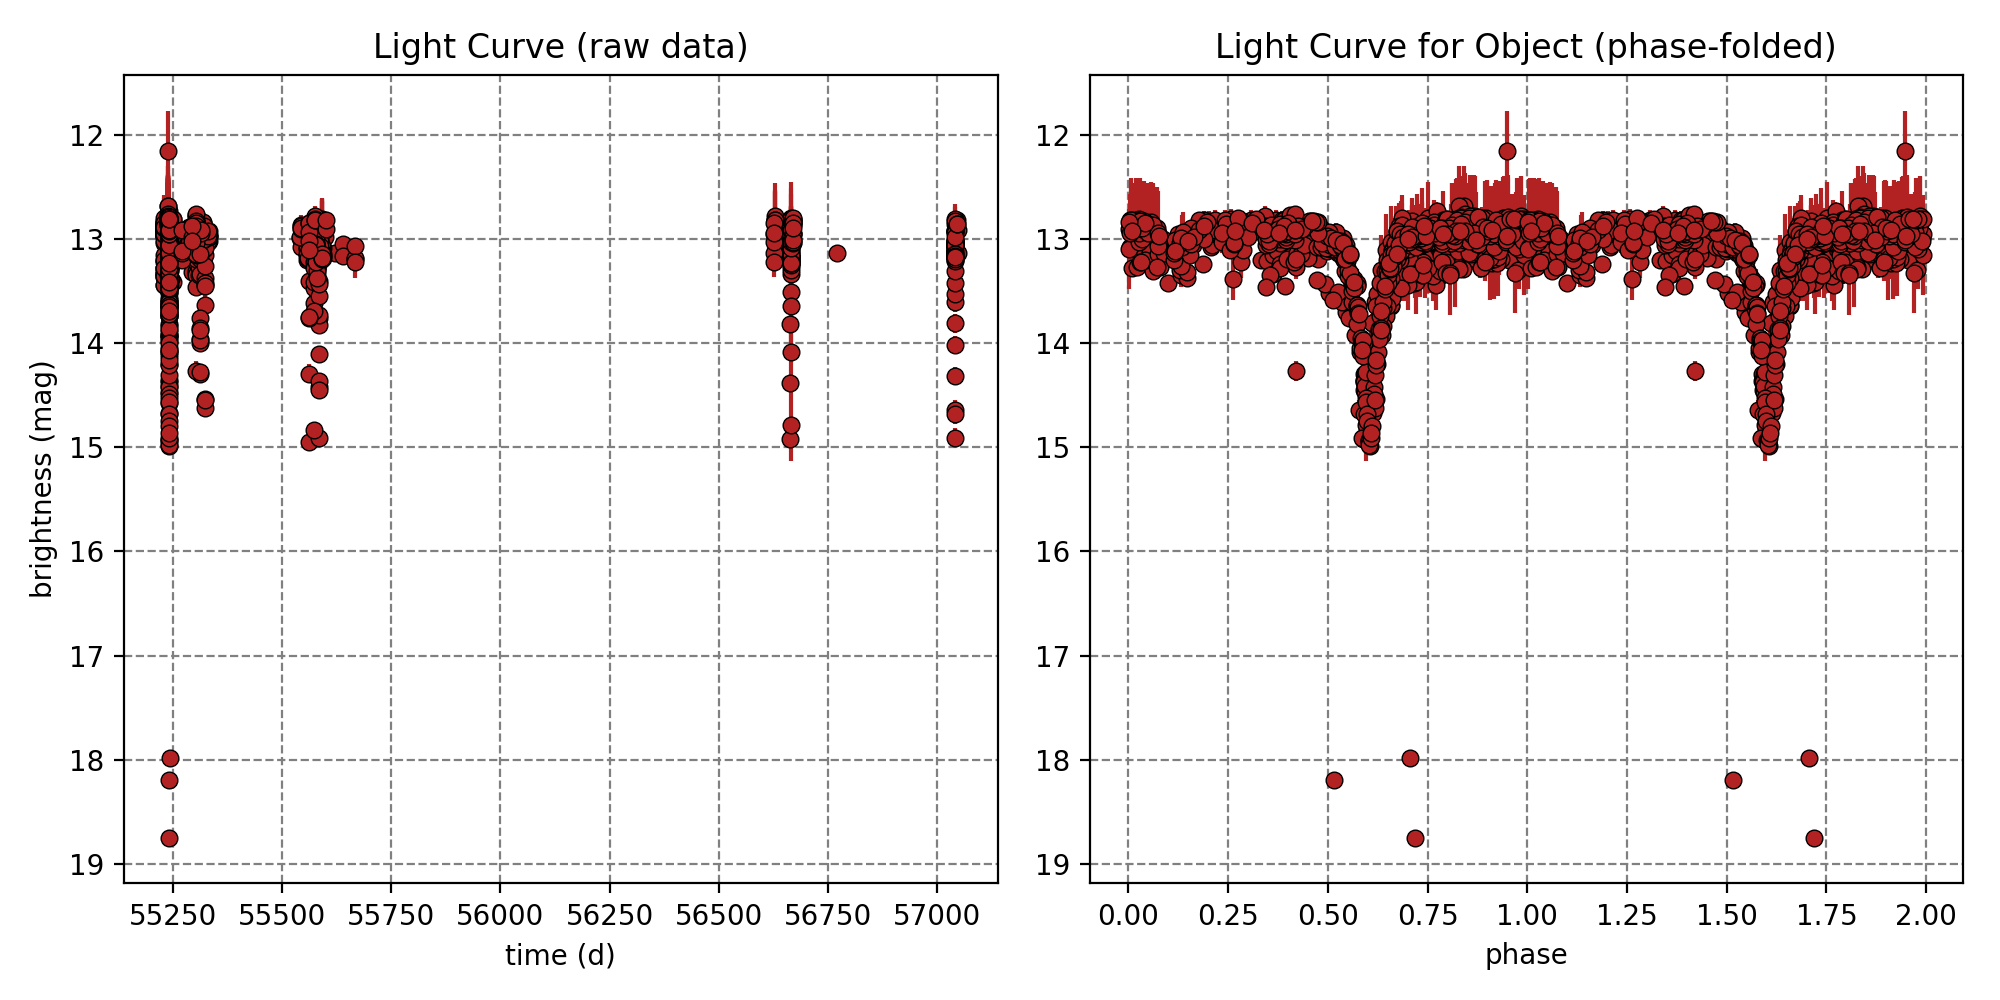

In [33]:
zoo_plot2(ipac_lc["obsmjd"], ipac_lc["mag_autocorr"], ipac_lc["magerr_auto"], period = 1.09296246931)

In [9]:
def zoo_plot3(dataTable, period):
    """ This is a fully general light curve plotting function that works with the dataTable
        downloaded from the Caltech IRSA website to produce phase-folded light curves and non-phase-folded
        light curves (i.e. the raw data) with error bars for each observation.

        Caltech IRSA website: http://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-scan?projshort=PTF

        Arguments:
            dataTable (array-like) : data table from Caltech IRSA website (.tbl)   
            period (float) : the period of the light curve for phase folding (obtained with cesium) 
    """

    times = dataTable["obsmjd"] 
    values = dataTable["mag_autocorr"] 
    errors = dataTable["magerr_auto"]
    oids = dataTable["oid"]
    fids = dataTable["fid"]

    length = len(oids)  
    oidsArray = np.empty(length)

    for i in range(length):
        oidsArray[i] = oids[i]

    oidsArraySorted = np.empty(length)
    oidsArraySorted = np.sort(oidsArray) 

    fmtToBeUsed = 'ro'

    index = 0
    swapVar = 0
    tempOID = 0
    newOID = int(oidsArraySorted[index])

    while newOID != tempOID: # while loop because number of unique OID's is not fixed 
        swapVar = newOID
        tempOID = swapVar

        indexesTempOID = np.where(dataTable[3][:] == tempOID)
        fmtToBeUsedNumber = fids[indexesTempOID[0][0]]

        # Filter identifier (1 = g; 2 = R)
        if fmtToBeUsedNumber == 2:
            fmtToBeUsed = 'ro'
        else:
            fmtToBeUsed = 'go'

        # returns figure object and axis object
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8,8), gridspec_kw = {'height_ratios':[1, 3]})
        
        # raw light curve
        ax1.errorbar(times[indexesTempOID], values[indexesTempOID], yerr=errors[indexesTempOID], fmt=fmtToBeUsed, 
            markersize=3, mec="k", mew=0.59)
        ax1.set_ylim(ax1.get_ylim()[::-1])
        ax1.set_title("Light Curve for Object {} (raw data)".format(tempOID))
        ax1.set_xlabel("time")
        ax1.set_ylabel("brightness (mag)")
        ax1.yaxis.grid(color='gray', linestyle='dashed')
        ax1.xaxis.grid(color='gray', linestyle='dashed')
            
        # phase-folded light curve
        tempLength = len(indexesTempOID[0])
        timesTemp = np.empty(tempLength)
        timesPhaseFolded = np.empty(tempLength)
        timesTemp = times[indexesTempOID]

        for i in range(tempLength):
            timesPhaseFolded[i] = (timesTemp[i] % period) / period

        timesPhaseFoldedPlusOne = np.empty(tempLength)
        for j in range(tempLength):
            timesPhaseFoldedPlusOne[j] = timesPhaseFolded[j]+1
        ax2.errorbar(timesPhaseFolded, values[indexesTempOID], yerr=errors[indexesTempOID], fmt=fmtToBeUsed, 
            markersize=3, mec="k", mew=0.59)
        ax2.set_ylim(ax2.get_ylim()[::-1]) # reversing the y-axis as desired  
        ax2.set_title("Light Curve for Object {} (phase-folded)".format(tempOID))
        ax2.set_xlabel("phase")
        ax2.set_ylabel("brightness (mag)")
        ax2.yaxis.grid(color='gray', linestyle='dashed')
        ax2.xaxis.grid(color='gray', linestyle='dashed')
        
        fig.tight_layout()
        plt.show()
        
        index += 1
        newOID = int(oidsArraySorted[index]) 
        # at this point, newOID will equal tempOID, unless the there is only one oid of that variety
        while (newOID == tempOID and index < (length-1)): 
            index += 1
            newOID = int(oidsArraySorted[index])

Enter .tbl filename: eb96.tbl
feature freq1_freq amplitude freq1_amplitude1
channel          0         0                0
0         1.829889     3.299         0.363264
Enter the frequency: 1.829889


<IPython.core.display.Javascript object>


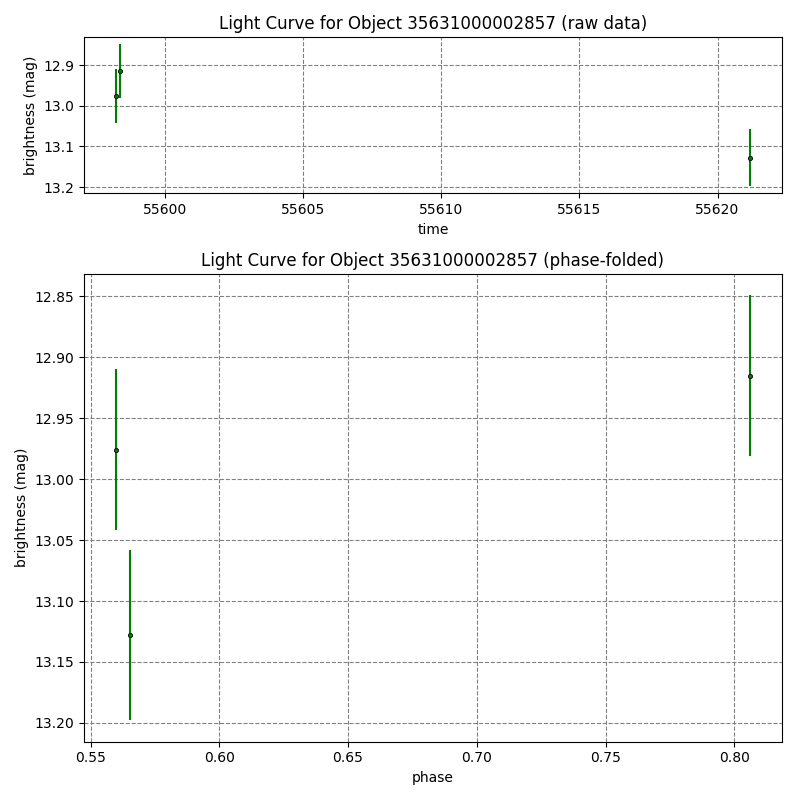

<IPython.core.display.Javascript object>


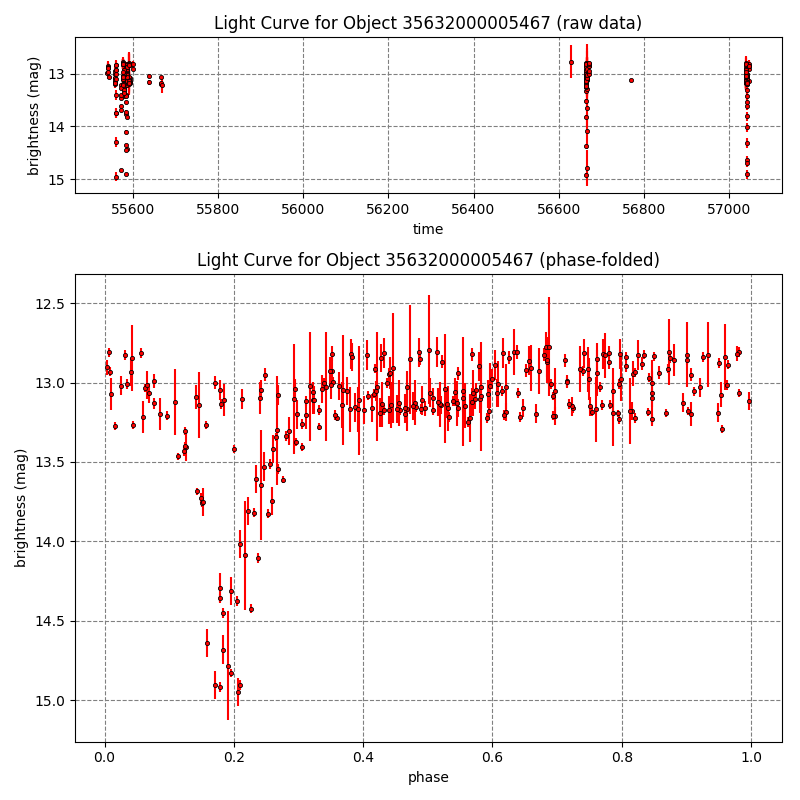

<IPython.core.display.Javascript object>


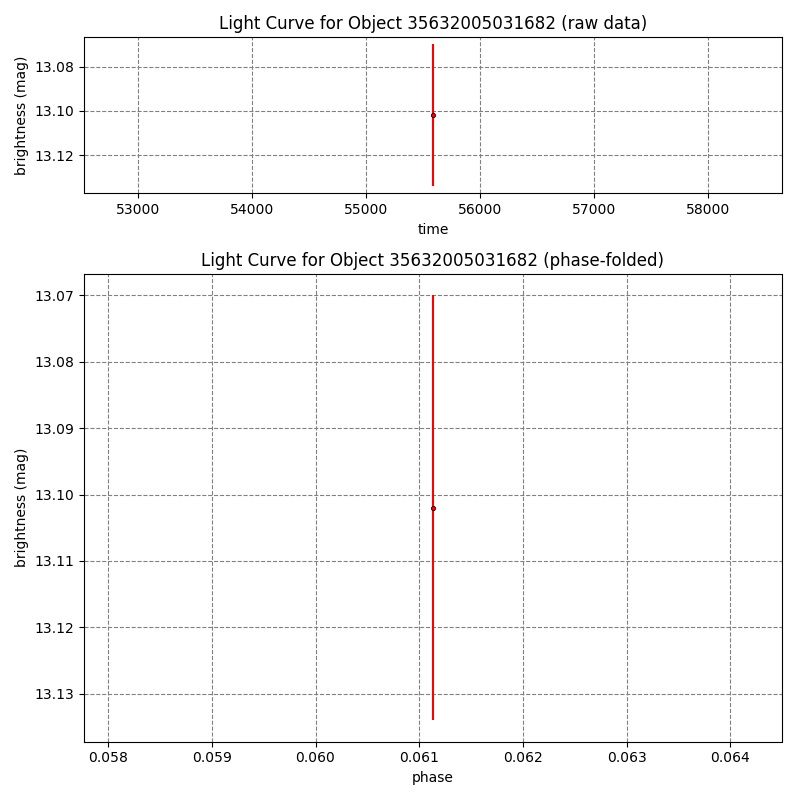

<IPython.core.display.Javascript object>


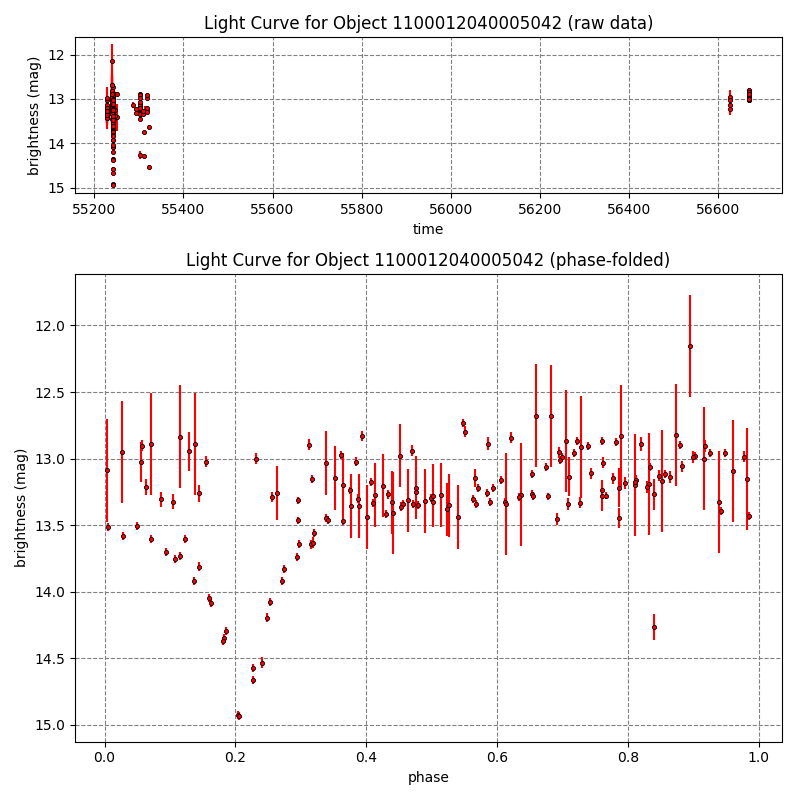

<IPython.core.display.Javascript object>


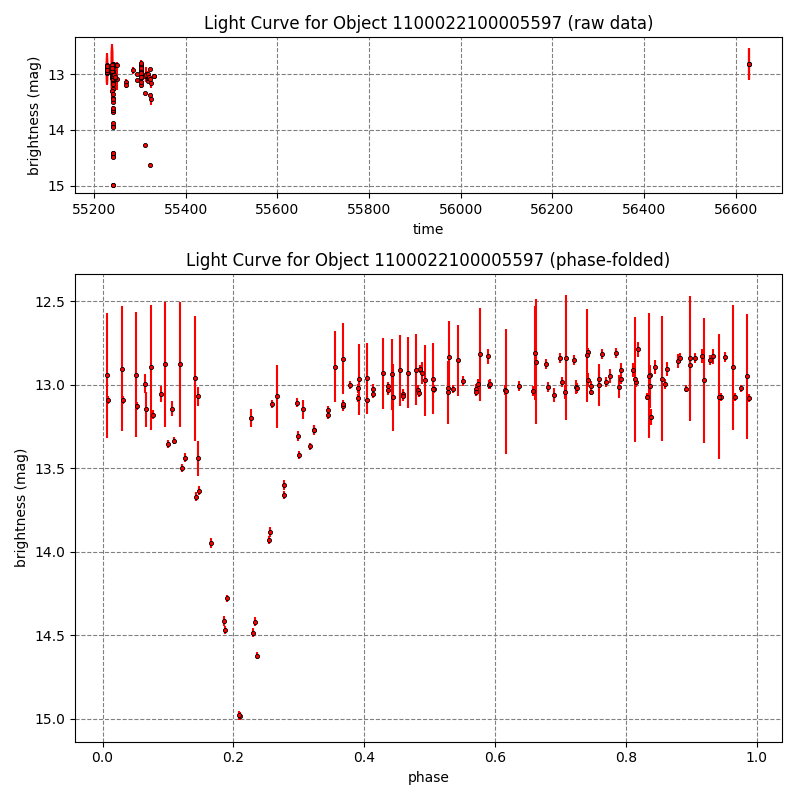

<IPython.core.display.Javascript object>


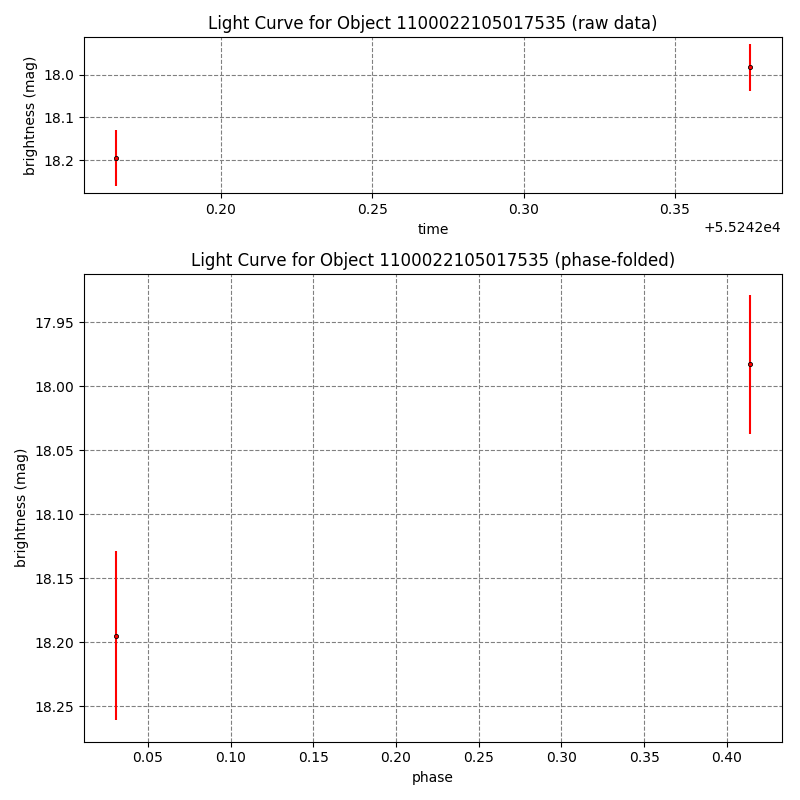

<IPython.core.display.Javascript object>


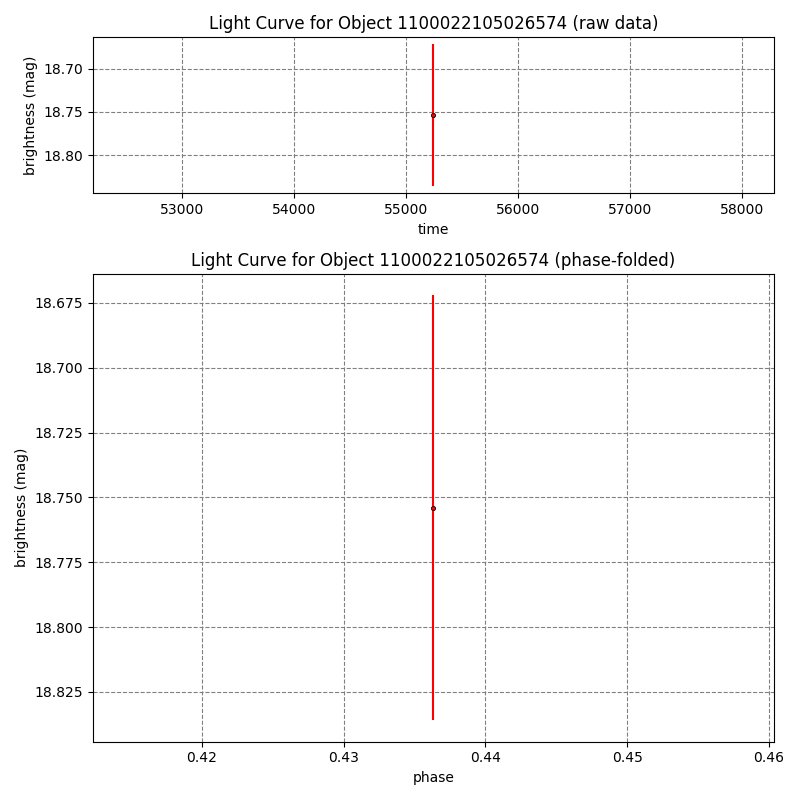

<IPython.core.display.Javascript object>


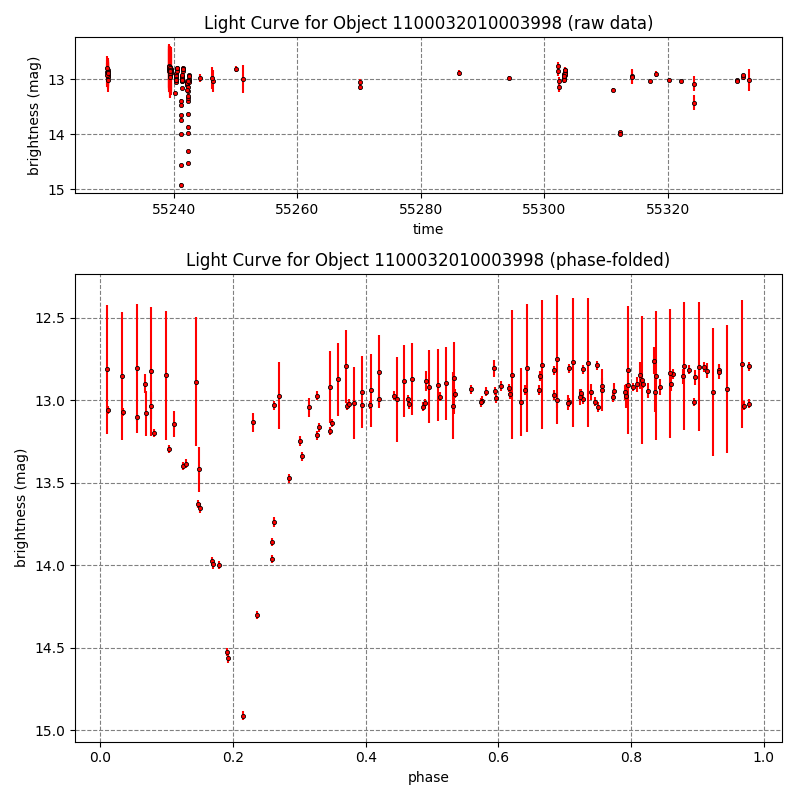

<IPython.core.display.Javascript object>


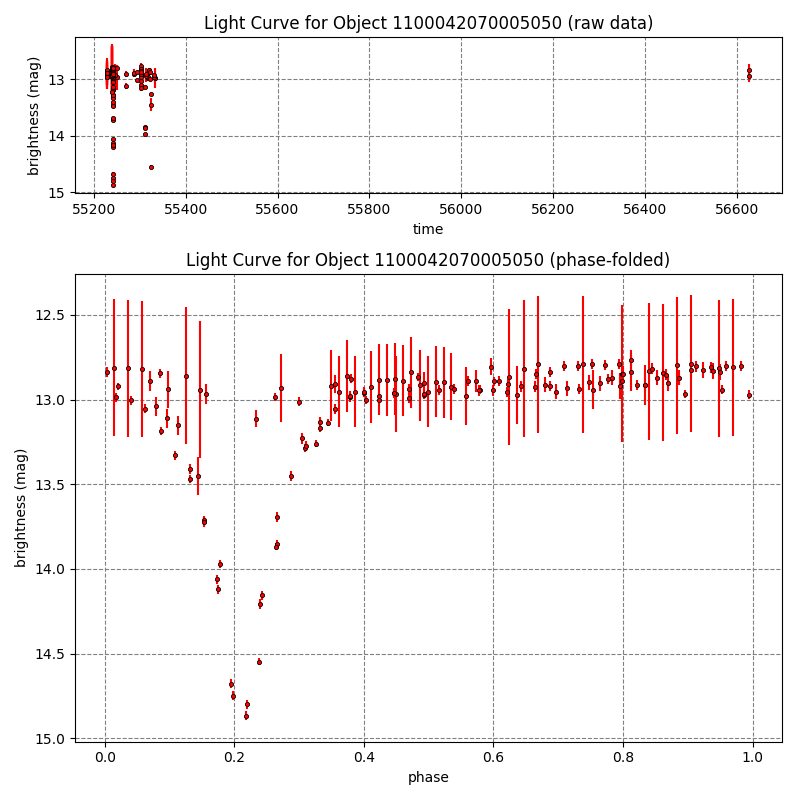

'period': 0.5464812346541238


In [11]:
filename = input("Enter .tbl filename: ")
dataTable = Table.read(filename, format='ipac')
printFrequency(dataTable)
frequency = float(input("Enter the frequency: "))
period = 1/frequency
zoo_plot3(dataTable, period)
print("'period':", period)